In [111]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import os
import urllib.request
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
import cv2
import os, glob, shutil
import seaborn as sns
from PIL import Image
# from numpy import linalg

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [112]:
#Loading Dataset
data = pd.read_csv("flipkart_com-ecommerce_sample.csv")

data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


In [113]:
#Getting Categories of the products from our Data Frame
categories = data.product_category_tree.values.tolist()
for i in range(len(categories)):
#     categories[i] = categories[i].split(" >> ")[0].lstrip('["').rstrip('"]')
    cat_tree = categories[i].split(" >> ")
    if len(cat_tree)>2:
        categories[i] = cat_tree[1] + " >> " + cat_tree[2] 
    elif len(cat_tree)== 2:
        categories[i] = cat_tree[0] + " >> " + cat_tree[1]
    else:
        categories[i] = categories[i].split(" >> ")[0].lstrip('["').rstrip('"]')
categories

["Women's Clothing >> Lingerie, Sleep & Swimwear",
 'Living Room Furniture >> Sofa Beds & Futons',
 "Women's Footwear >> Ballerinas",
 "Women's Clothing >> Lingerie, Sleep & Swimwear",
 'Grooming >> Skin & Coat Care',
 'Eternal Gandhi Super Series Crystal Paper Weight...',
 "Women's Clothing >> Lingerie, Sleep & Swimwear",
 'Living Room Furniture >> Sofa Beds & Futons',
 "Women's Footwear >> Ballerinas",
 "Women's Clothing >> Lingerie, Sleep & Swimwear",
 "Women's Footwear >> Ballerinas",
 "Women's Clothing >> Sports & Gym Wear",
 'Grooming >> Skin & Coat Care',
 "Women's Clothing >> Lingerie, Sleep & Swimwear",
 'School Supplies >> Water Bottles',
 "Women's Clothing >> Lingerie, Sleep & Swimwear",
 'Living Room Furniture >> Sofa Beds & Futons',
 "Women's Footwear >> Ballerinas",
 "Women's Clothing >> Sports & Gym Wear",
 'Living Room Furniture >> Sofa Beds & Futons',
 'Grooming >> Skin & Coat Care',
 "Women's Clothing >> Lingerie, Sleep & Swimwear",
 "Kids' Clothing >> Boys Wear",
 "W

In [114]:
#User Input for product category
menu = dict(zip([i for i in range(1,len(categories)+1)],categories))
menu

{1: "Women's Clothing >> Lingerie, Sleep & Swimwear",
 2: 'Living Room Furniture >> Sofa Beds & Futons',
 3: "Women's Footwear >> Ballerinas",
 4: "Women's Clothing >> Lingerie, Sleep & Swimwear",
 5: 'Grooming >> Skin & Coat Care',
 6: 'Eternal Gandhi Super Series Crystal Paper Weight...',
 7: "Women's Clothing >> Lingerie, Sleep & Swimwear",
 8: 'Living Room Furniture >> Sofa Beds & Futons',
 9: "Women's Footwear >> Ballerinas",
 10: "Women's Clothing >> Lingerie, Sleep & Swimwear",
 11: "Women's Footwear >> Ballerinas",
 12: "Women's Clothing >> Sports & Gym Wear",
 13: 'Grooming >> Skin & Coat Care',
 14: "Women's Clothing >> Lingerie, Sleep & Swimwear",
 15: 'School Supplies >> Water Bottles',
 16: "Women's Clothing >> Lingerie, Sleep & Swimwear",
 17: 'Living Room Furniture >> Sofa Beds & Futons',
 18: "Women's Footwear >> Ballerinas",
 19: "Women's Clothing >> Sports & Gym Wear",
 20: 'Living Room Furniture >> Sofa Beds & Futons',
 21: 'Grooming >> Skin & Coat Care',
 22: "Women

In [115]:
user_choice = int(input("Enter your choice number: "))
user_cat = menu[user_choice]

Enter your choice number: 85


In [116]:
data_df = pd.DataFrame(data)
category_df = data_df[data_df['product_category_tree'].str.contains(user_cat)]
category_df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
84,a99bd685c5430bdf45a1dd01aabc3200,2016-06-06 22:03:00 +0000,http://www.flipkart.com/redbag-eight-armed-god...,Redbag Eight Armed Goddess Sherawali Maa Showp...,"[""Home Decor & Festive Needs >> Table Decor & ...",SHIEJYHMR7DUKT8W,1600.0,1200.0,"[""http://img6a.flixcart.com/image/showpiece-fi...",False,Key Features of Redbag Eight Armed Goddess She...,No rating available,No rating available,Redbag,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
918,cf8034d3672622338718fa664d83140c,2016-01-04 04:41:20 +0000,http://www.flipkart.com/kalabhawan-stair-sculp...,KalaBhawan Stair Sculpture Showpiece - 39 cm,"[""Home Decor & Festive Needs >> Table Decor & ...",SHIEBPPVHHH8Z3KE,2199.0,1399.0,"[""http://img5a.flixcart.com/image/showpiece-fi...",False,Buy KalaBhawan Stair Sculpture Showpiece - 3...,No rating available,No rating available,KalaBhawan,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1381,4e130ed339dcfe20d2c8b66892278a94,2016-03-10 07:45:58 +0000,http://www.flipkart.com/treasure-showpiece-23-...,Treasure Showpiece - 23 cm,"[""Home Decor & Festive Needs >> Table Decor & ...",SHIEGHNCZBRTKZCR,699.0,399.0,"[""http://img5a.flixcart.com/image/showpiece-fi...",False,Key Features of Treasure Showpiece - 23 cm P...,No rating available,No rating available,Treasure,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1525,181914cbb519a98425885d147829baef,2016-01-04 00:20:04 +0000,http://www.flipkart.com/diviniti-dg-royal-orna...,Diviniti DG Royal Ornamental Size 4 Allha reli...,"[""Home Decor & Festive Needs >> Table Decor & ...",SHIEBBWHC4YGH5GY,17460.0,17460.0,"[""http://img6a.flixcart.com/image/showpiece-fi...",False,Diviniti DG Royal Ornamental Size 4 Allha reli...,No rating available,No rating available,Diviniti,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1535,bd59f01525ff2fd65f81e0d6e8eb714e,2016-01-04 00:20:04 +0000,http://www.flipkart.com/diviniti-dg-royal-orna...,Diviniti DG Royal Ornamental Size 4.5 Murgan J...,"[""Home Decor & Festive Needs >> Table Decor & ...",SHIEBBWHAJKSZDTG,47620.0,47620.0,"[""http://img6a.flixcart.com/image/showpiece-fi...",False,Diviniti DG Royal Ornamental Size 4.5 Murgan J...,No rating available,No rating available,Diviniti,"{""product_specification""=>[{""key""=>""Brand"", ""v..."


In [117]:
img_urls = category_df.image.values.tolist()
crawl_urls = []
for i in range(len(img_urls)):
    crawl_urls.append(str(img_urls[i]).lstrip('["').rstrip('"]').split('", "'))
crawl_urls = [url for urls in crawl_urls for url in urls]
ct = 1
try:
    for url in crawl_urls:
        urllib.request.urlretrieve(url, 'crawl-images/{}.jpg'.format(ct))
        ct += 1
except requests.HTTPError as exception:
    pass

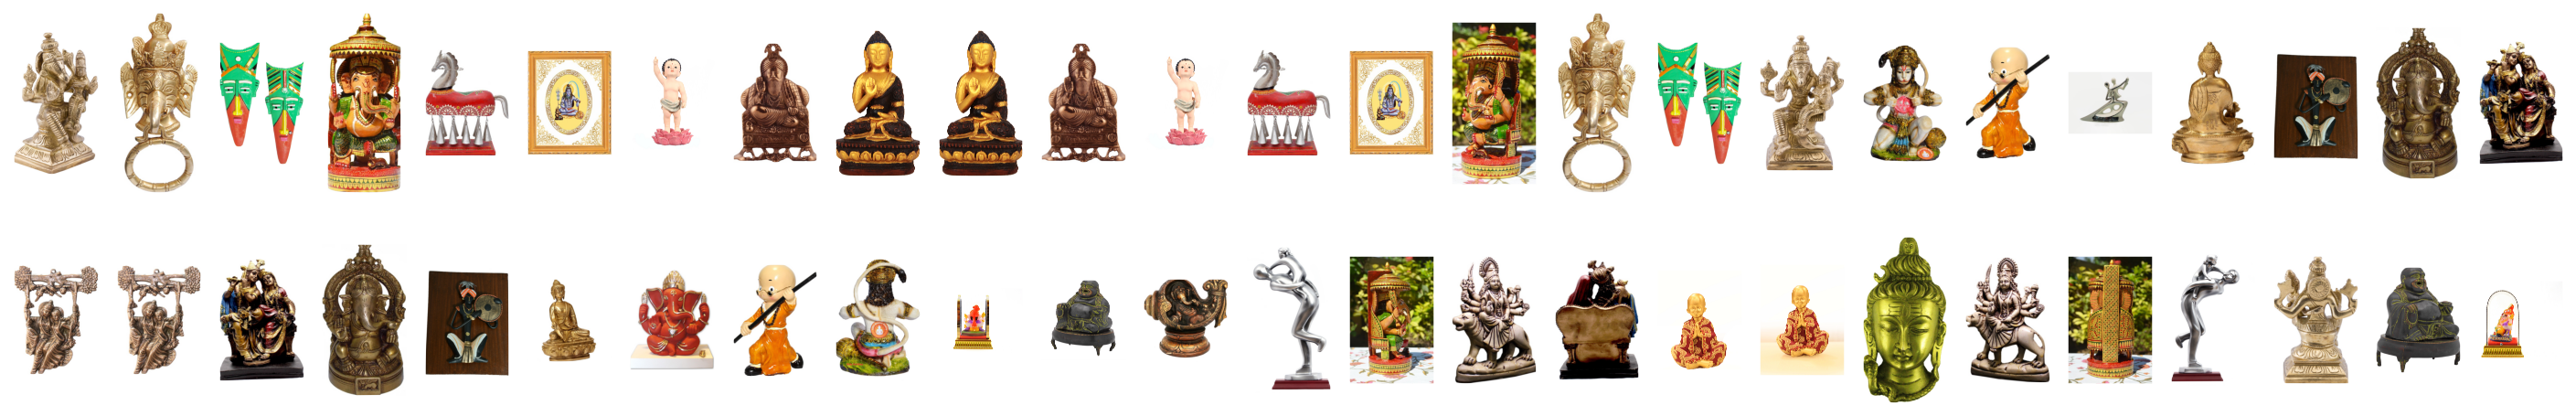

In [118]:
#Displaying All The Crawled Images
filelist = glob.glob('crawl-images/*')
images = np.array([np.array(Image.open(fname)) for fname in filelist])

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(50):
    ax = fig.add_subplot(2, 50/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])

# Using Pretrained Resnet50 from Keras To Perform KMeans Clustering

In [119]:
img_dir = 'crawl-images/*.jpg'
# Converting Images to numpy and storing their paths
images = [cv2.resize(cv2.imread(file),(224, 224)) for file in glob.glob(img_dir)]
paths = [file for file in glob.glob(img_dir)]
images = np.array(np.float32(images).reshape(len(images), -1)/ 255)

In [120]:
#Loading ResNet50 which has been trained in ImageNet.
model = tf.keras.applications.ResNet50(include_top = False, weights = 'imagenet', input_shape = (224,224,3))
predictions = model.predict(images.reshape(-1, 224, 224, 3))
pred_images = predictions.reshape(images.shape[0], -1)
# Clustering
k = 3
kmodel = KMeans(n_clusters = k, n_jobs = -1, random_state = 25111993)
kmodel.fit(pred_images)
kpredictions = kmodel.predict(pred_images)
for i in range(k):
    os.makedirs("cluster"+ str(i))
    
for i in range(len(paths)):
    shutil.copy2(paths[i], "cluster"+str(kpredictions[i]))

/Users/adityasalian/opt/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/Users/adityasalian/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


# Representing the Image clusters

I have tried to use t-sne distribution lirbary to flatten the image vectors from the Resnet model and display the clusters in a scatter plot. However, since the data is just of 30 images, the scatter plot does not exactly capture the differences. Secondly, I have tried representing the image clusters using a table with all the images and their repsective clusters. Lastly, I have plotted some images and their corresponding cluster number as the title. 

In [121]:
#Plotting in TSNE
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [122]:
y = kmodel.labels_
z = pd.DataFrame(y.tolist())
tsne_proj = TSNE(random_state= 2511199).fit_transform(pred_images)

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.collections.PathCollection at 0x7fd3f0b64d50>)

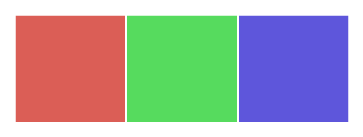

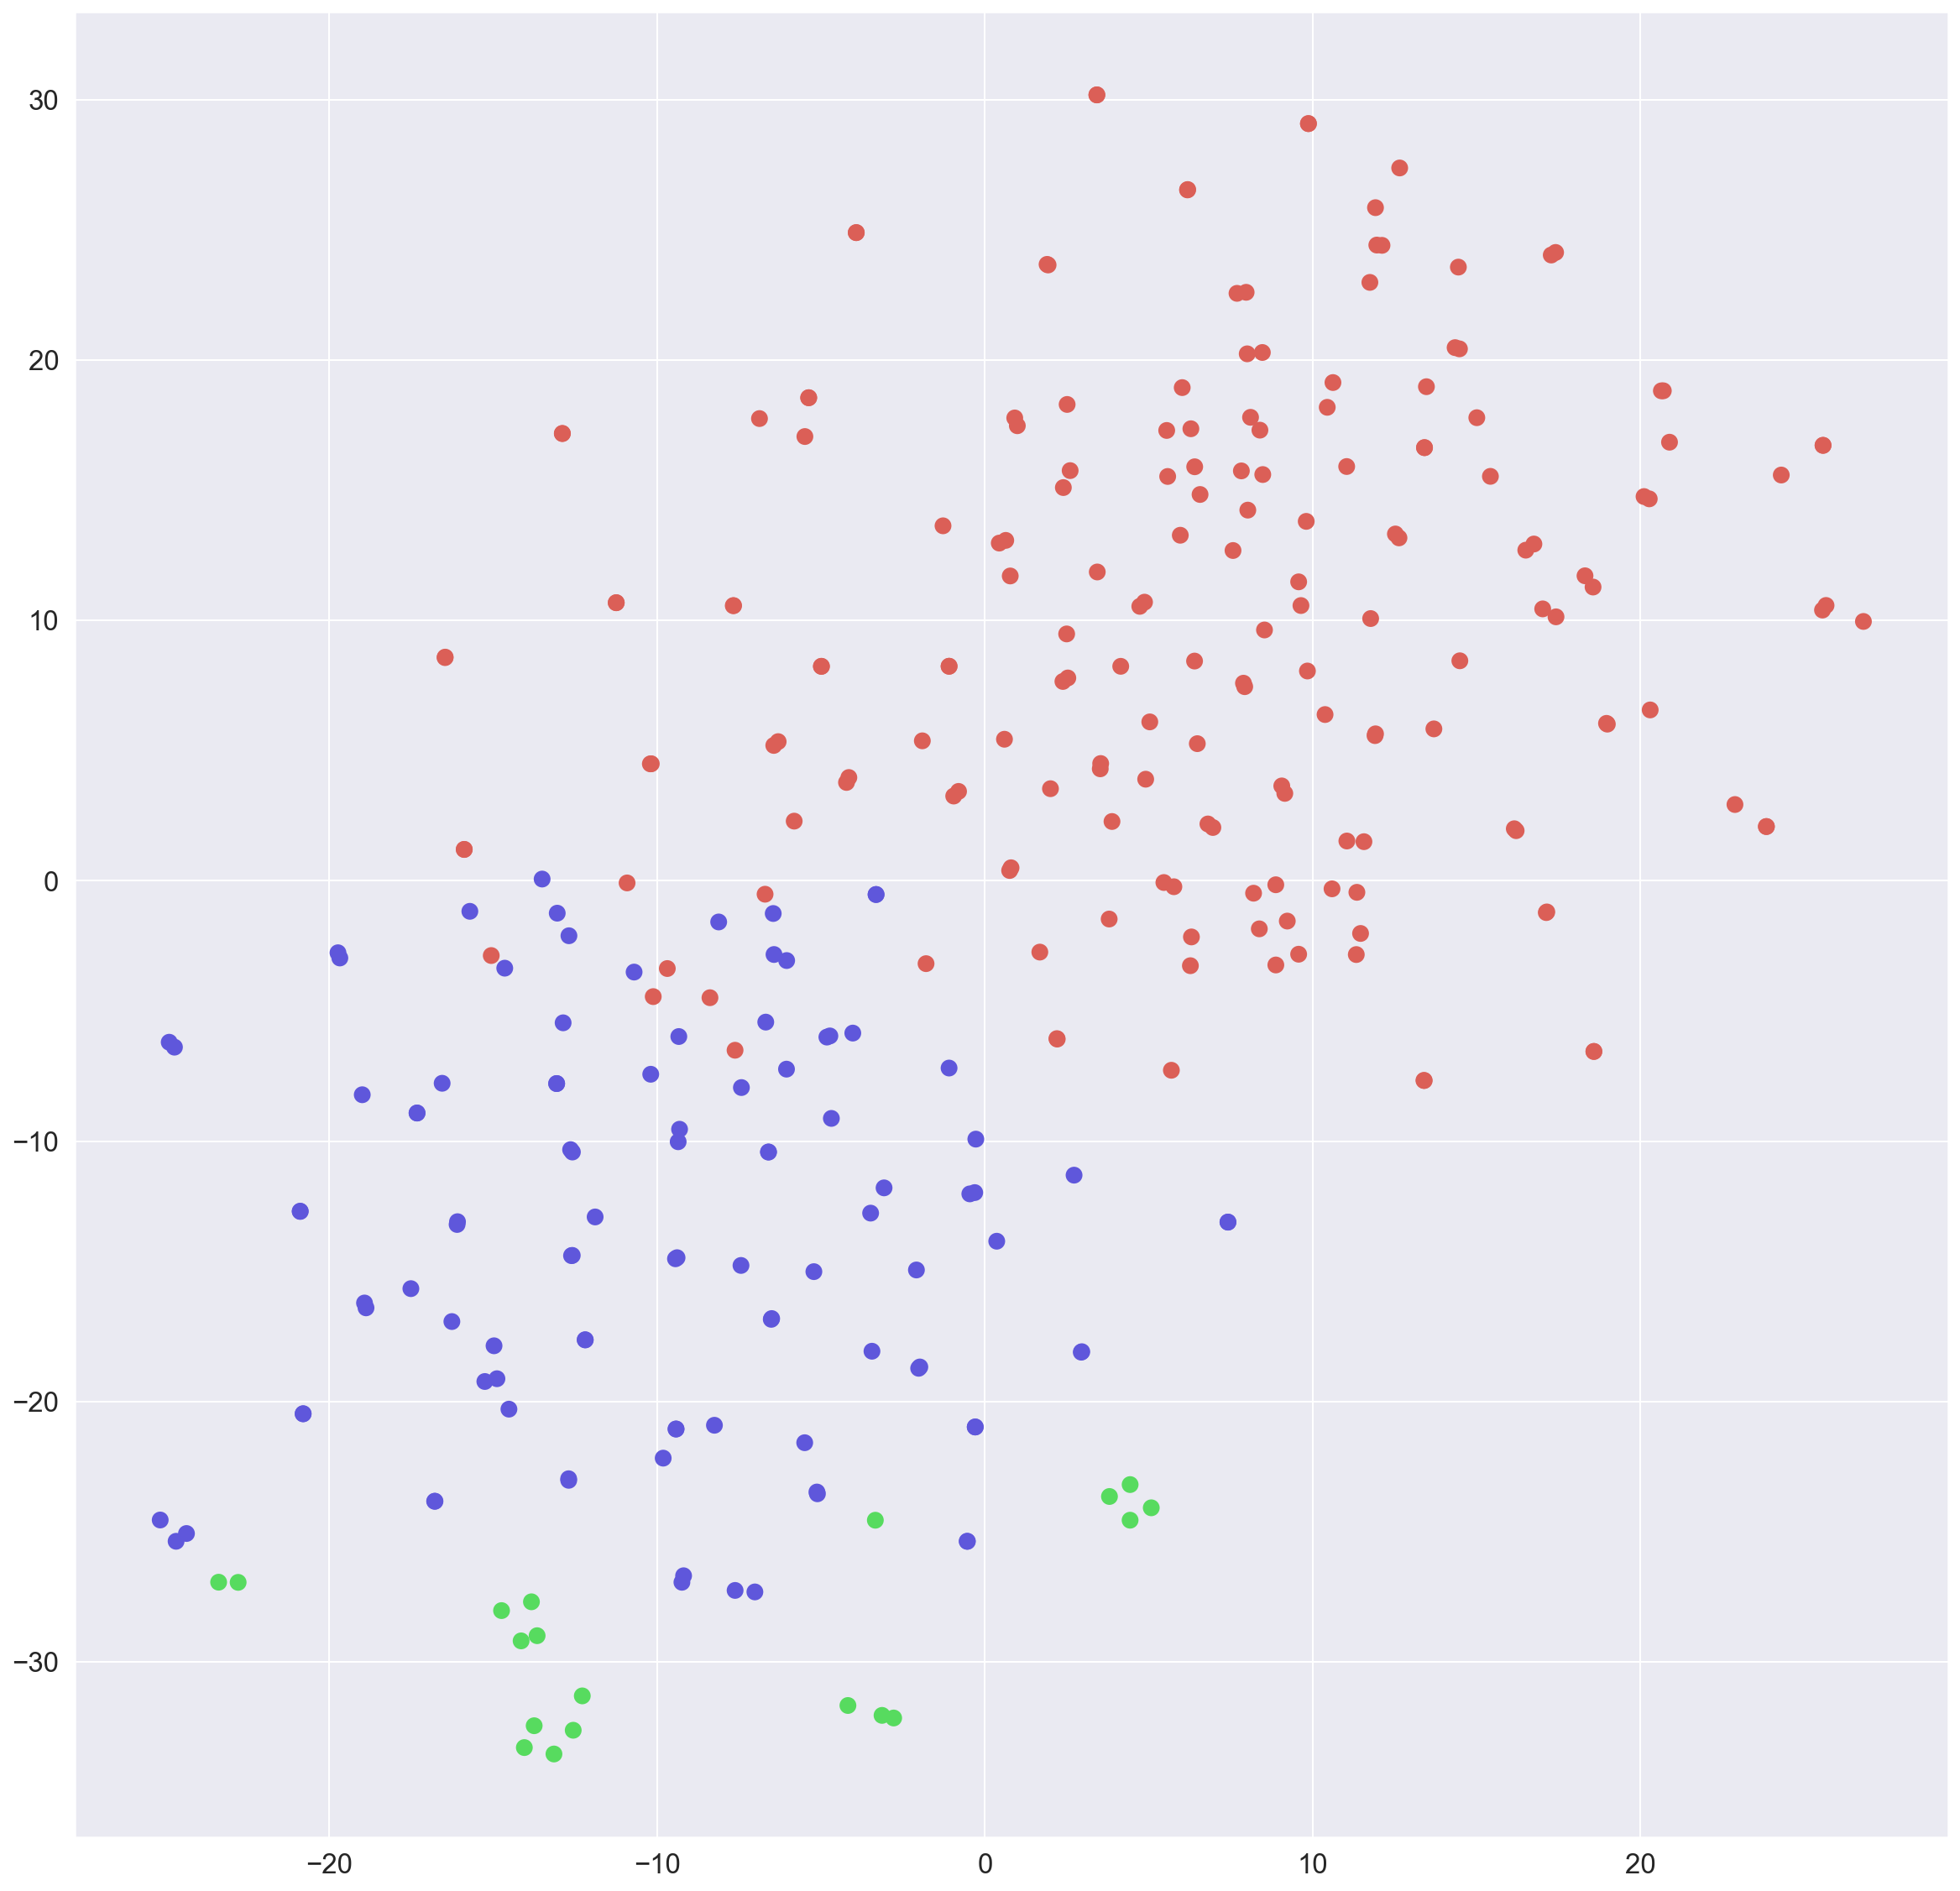

In [123]:
def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", 3))
    f = plt.figure(figsize=(20, 20))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=100,
                    c=palette[colors.astype(np.int)])
    ax.axis('on')
    ax.axis('tight')
    return f, ax, sc

sns.palplot(np.array(sns.color_palette("hls", 3)))
scatter(tsne_proj, kpredictions)

In [124]:
#Table of the images and their respective clusters
cluster_table = pd.DataFrame(columns = ['Image', 'Cluster'])
cluster_table['Image'] = pd.Series(paths)
cluster_table['Cluster'] = pd.Series(y)
cluster_table

,Image,Cluster
0,crawl-images/63.jpg,0
1,crawl-images/189.jpg,0
2,crawl-images/77.jpg,0
3,crawl-images/162.jpg,2
4,crawl-images/176.jpg,0
...,...,...
294,crawl-images/147.jpg,0
295,crawl-images/52.jpg,0
296,crawl-images/46.jpg,0
297,crawl-images/190.jpg,2


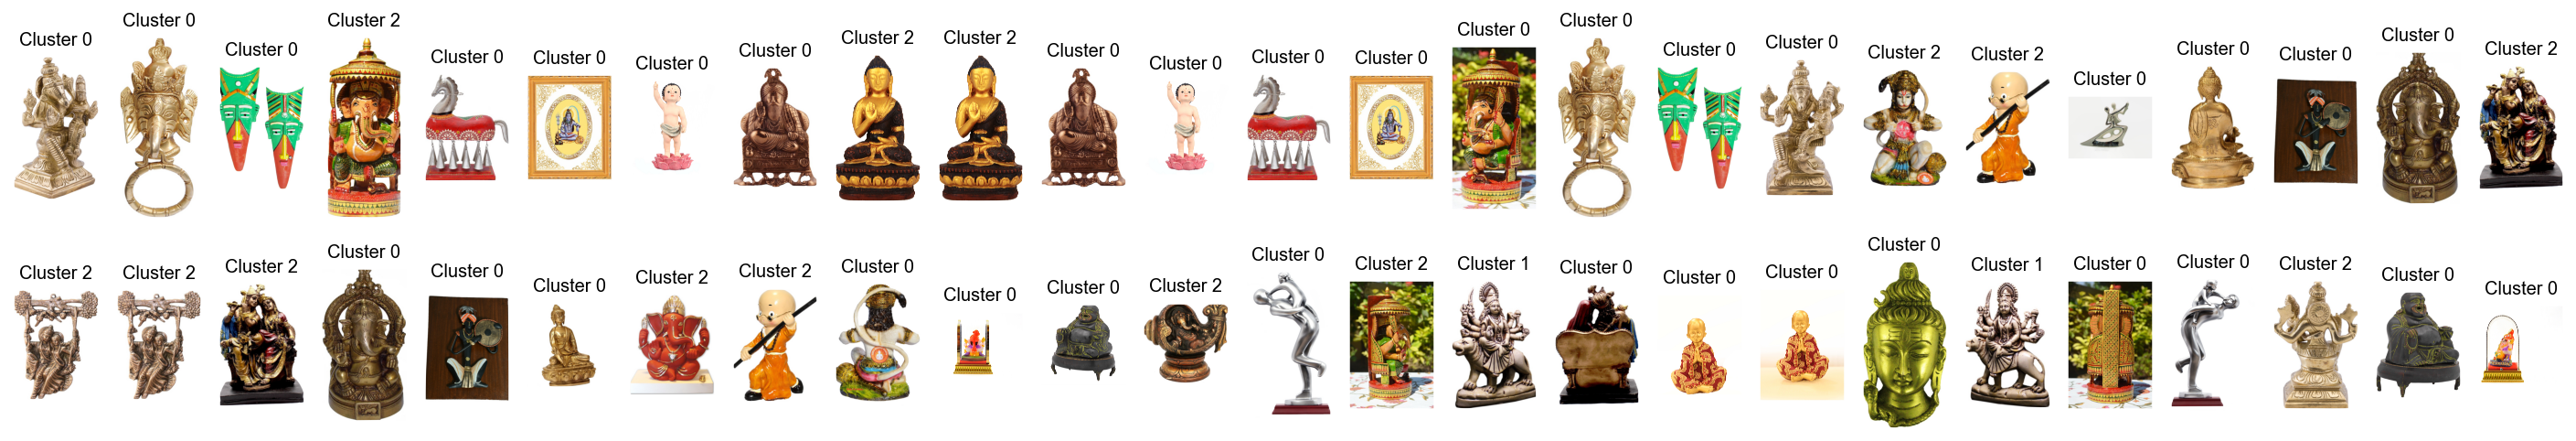

In [125]:
#Showing Some images with their cluster as the title
filelist = glob.glob('crawl-images/*')
images = np.array([np.array(Image.open(fname)) for fname in filelist])
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(50):
    axis = fig.add_subplot(2, 50/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])
    axis.set_title("Cluster {}".format(y[idx]), color=("black"), fontsize= 10)